In [1]:
import gzip
from pprint import pprint
from imp import reload
import pandas

import pygbrowse

## Download GFF3 file

## Just plot gene models

In [3]:
%%time
gff3_fname = '/home/dskola/glass_home/model_data/reference_genomes/mm10/Mus_musculus.GRCm38.84.chr.gff3.gz'
assert gzip.open(gff3_fname).readline().decode().strip() == '##gff-version   3', 'First line does not indicate a GFF3 file. Currently only GFF3 annotations are supported.'
gff_data = pandas.read_csv(gff3_fname,
                           sep='\t',
                           comment='#', 
                           header=None, 
                           names=['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'],
                           dtype={'seqid':str, 'source':str, 'type':str, 'start':int, 'end':int, 'score':str, 'strand':str, 'phase':str, 'attributes':str})


CPU times: user 5.58 s, sys: 468 ms, total: 6.04 s
Wall time: 9.65 s


In [4]:
reload(pygbrowse)
reload(pygbrowse.plots)

<module 'pygbrowse.plots' from '/home/dskola/workspace/python-genome-browser/pygbrowse/plots.py'>

In [5]:
%time gene_models = pygbrowse.plots.GeneModels(gff3_fname)

2018-Jul-24 16:49:59	Loading gene model information from /home/dskola/glass_home/model_data/reference_genomes/mm10/Mus_musculus.GRCm38.84.chr.gff3.gz. This may take a few minutes ...
CPU times: user 1min 13s, sys: 1.5 s, total: 1min 15s
Wall time: 1min 17s


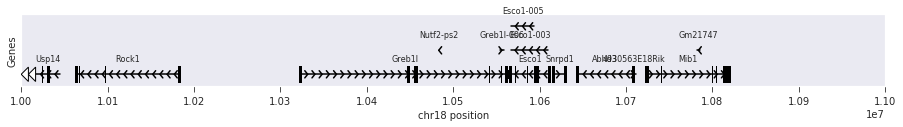

In [6]:
fig = pygbrowse.plots.visualize(plot_objects=[[gene_models]], chrom='chr18', ws=10000000, we=11*1e6)

## Continuous data

## Idea: Leave the tag data on disk and create vectors on the fly. Would need to grab the appropriate chromosome file and then do a binary search to find the correct start point (then iterate until end). We could do something similar for gene models

## Add convenience function for generating chromosome dicts from a single region (chrom, start end`)

In [7]:
reload(pygbrowse)
reload(pygbrowse.datasources)
reload(pygbrowse.utilities)

tag_directory = '/home/dskola/glass_data/mm10/BMDM/RNA/C57_BMDM_polyA_RNA_notx_BC_16_03_08/'
rnaseq_data = pygbrowse.datasources.TagDirectory(tag_directory)

## We can query the data backend

In [8]:
%time res = rnaseq_data.query('chr18', 10009970, 10010000)
print(res)

CPU times: user 48 ms, sys: 16 ms, total: 64 ms
Wall time: 259 ms
10009970    0.000000
10009971    0.000000
10009972    0.000000
10009973    0.000000
10009974    2.380023
10009975    0.000000
10009976    0.000000
10009977    2.380023
10009978    0.000000
10009979    0.000000
10009980    2.380023
10009981    0.000000
10009982    4.760047
10009983    7.140070
10009984    0.000000
10009985    4.760047
10009986    0.000000
10009987    0.000000
10009988    2.380023
10009989    0.000000
10009990    4.760047
10009991    0.000000
10009992    0.000000
10009993    0.000000
10009994    0.000000
10009995    0.000000
10009996    0.000000
10009997    0.000000
10009998    0.000000
10009999    0.000000
dtype: float64


## Plot

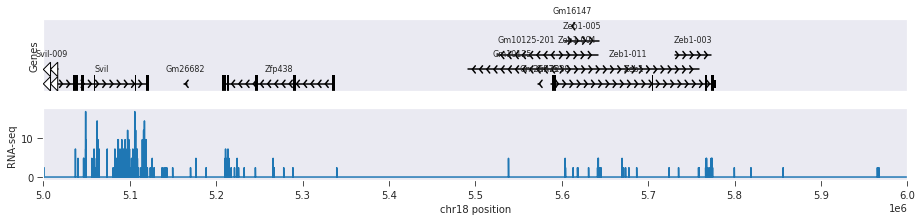

In [9]:
reload(pygbrowse.utilities)
reload(pygbrowse.datasources)
reload(pygbrowse.plots)

rnaseq_data = pygbrowse.datasources.TagDirectory(tag_directory)

rnaseq_plot = pygbrowse.plots.WigPlot(rnaseq_data, label='RNA-seq', scale_vector_to_plot=False)
fig = pygbrowse.plots.visualize(plot_objects=[[gene_models], 
                                              [rnaseq_plot]], chrom='chr18', ws=5000000, we=6*1e6)

In [10]:
import numpy
a = {'chr18':pandas.Series(numpy.arange(5000000, 6000000), index=numpy.arange(5000000, 6000000))}

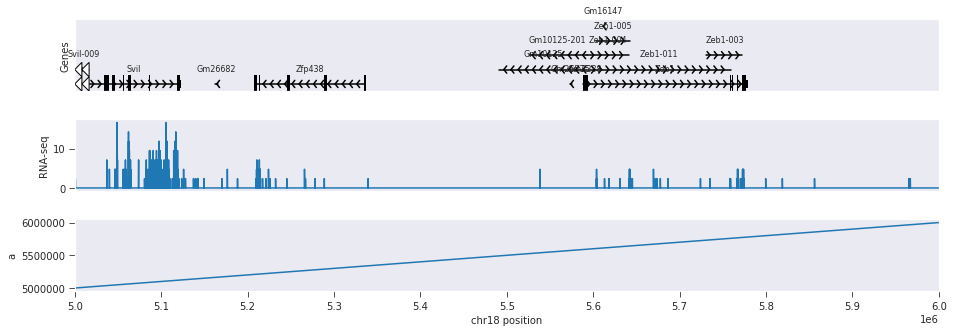

In [11]:
a_plot = pygbrowse.plots.WigPlot(a, label='a', scale_vector_to_plot=False)
fig = pygbrowse.plots.visualize(plot_objects=[[gene_models], 
                                              [rnaseq_plot],
                                             [a_plot]], chrom='chr18', ws=5000000, we=6*1e6)

In [12]:
a_plot = pygbrowse.plots.WigPlot(a, label='a', scale_vector_to_plot=False)

In [13]:
reload(pygbrowse.plots)
placseq_interaction_fname = '/home/dskola/glass_home/projects/coupled_peaks/placseq/significance_table_all_strains.txt'

placseq_interaction_plot = pygbrowse.plots.InteractionPlot(pandas.read_csv(placseq_interaction_fname, sep=','), bin_size=5000)

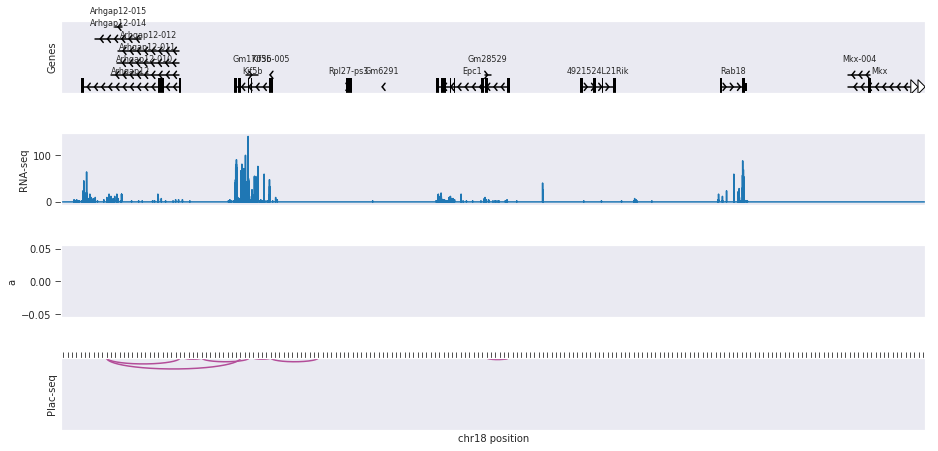

In [14]:
# %%prun

fig = pygbrowse.plots.visualize(plot_objects=[[gene_models],
                                              [rnaseq_plot],
                                              [a_plot], 
                                              [placseq_interaction_plot]],
                                chrom='chr18', ws=6000000, we=7*1e6)


## Intervals (BED files)

In [15]:
reload(pygbrowse.datasources)
reload(pygbrowse.plots)

pu1_peak_data_bed = pygbrowse.datasources.IntervalData('/home/dskola/glass_home/projects/coupled_peaks/moremerged/peaks/pooled_pu1_notx_c57.bed',
                                                  format='bed')

pu1_peak_data_homer = pygbrowse.datasources.IntervalData('/home/dskola/glass_home/projects/coupled_peaks/moremerged/peaks/pooled_pu1_notx_c57.homer',
                                                  format='homer')

pu1_peak_data_annotated = pygbrowse.datasources.IntervalData('/home/dskola/glass_home/projects/coupled_peaks/moremerged/peaks/pooled_pu1_notx_c57_annotated.homer',
                                                  format='homer_annotated')

2018-Jul-24 16:51:38	Guessing /home/dskola/glass_home/projects/coupled_peaks/moremerged/peaks/pooled_pu1_notx_c57.bed is a filename
2018-Jul-24 16:51:40	Guessing /home/dskola/glass_home/projects/coupled_peaks/moremerged/peaks/pooled_pu1_notx_c57.homer is a filename
2018-Jul-24 16:51:43	Guessing /home/dskola/glass_home/projects/coupled_peaks/moremerged/peaks/pooled_pu1_notx_c57_annotated.homer is a filename


## Interface decision:
* Should we automate the data backend generation by allowing users to specify a flexible data source (string filename, data object plus parameter to specify type where appropriate?

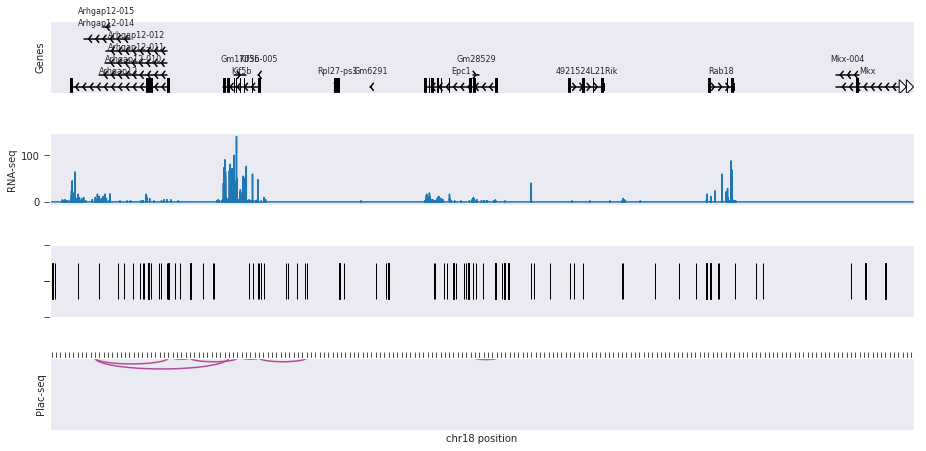

In [17]:
reload(pygbrowse.datasources)
reload(pygbrowse.plots)
pu1_peak_plot = pygbrowse.plots.BedPlot(pu1_peak_data_homer, label='Pu.1 peaks')


fig = pygbrowse.plots.visualize(plot_objects=[[gene_models],
                                              [rnaseq_plot],
                                              [pu1_peak_plot], 
                                              [placseq_interaction_plot]],
                                chrom='chr18', ws=6000000, we=7*1e6)

## Show how to construct your own custom plotting function that just takes coordinates.
    * Starting to feel like we should make the visualizer an object.
    
            * Create a visualization object with all the parameters, then that exposes a method that just takes chrom, start, end. That _is_ the custom plotting function.

# Create universal interface for continuous and interval data?